# Logits to Categorical Distribution

In [1]:
import os
import sys
import math
import time
import random
import tempfile
from functools import reduce
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.special import softmax

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.distributions import MultivariateNormal

from utils.visualization import plot_prob_simplex, plot_cal_regions_ternary
from ternary.helpers import project_sequence
from flows.flows import Flow, AffineConstantLayer, NvpCouplingLayer, PlanarLayer

In [2]:
%matplotlib inline
plt.ioff()

In [29]:
PI = torch.Tensor([math.pi])
n_layers = 5  # Layers to monitor
epochs = 10000

save = False
save_path = r"C:\Users\sergi\Google Drive\calibration-ml\ongoing\logits2categorical"
data_path = '../data/toys/'
dev = torch.device('cpu')

# Simulated data
n_samples = 1500
dim = 3

In [4]:
def create_animation_logits(intermediate_results, target):
    
    preds = intermediate_results[0]
    
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(20, 45)

    sc = ax.scatter(preds[:, 0], preds[:, 1], preds[:, 2], c=target)

    # manually relim:
    xmin = 1e7; xmax = 1e-7;
    ymin = 1e7; ymax = 1e-7;
    zmin = 1e7; zmax = 1e-7;
    for preds in intermediate_results:
        xmin=min(preds[:,0].min(), xmin); xmax=max(preds[:,0].max(), xmax)
        ymin=min(preds[:,1].min(), ymin); ymax=max(preds[:,1].max(), ymax)
        zmin=min(preds[:,2].min(), zmin); zmax=max(preds[:,2].max(), zmax)

    xmin = max(xmin, -10.); xmax = min(xmax, 10.)
    ymin = max(xmin, -10.); ymax = min(ymax, 10.)
    zmin = max(xmin, -10.); zmax = min(zmax, 10.)

    ax.set_xlim(xmin-0.1*(xmax-xmin),xmax+0.1*(xmax-xmin))
    ax.set_ylim(ymin-0.1*(ymax-ymin),ymax+0.1*(ymax-ymin))
    ax.set_zlim(zmin-0.1*(zmax-zmin),zmax+0.1*(zmax-zmin))

    def update_scat(i):
        preds = intermediate_results[i]
        sc._offsets3d = (preds[:, 0], preds[:, 1], preds[:, 2])

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    plt.close(fig)
    
    return ani

In [5]:
def create_animation_probs3d(intermediate_results, target):
    
    preds = intermediate_results[0]
    
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(20, 45)

    probs = softmax(intermediate_results[0], 1)
    
    sc = ax.scatter(probs[:, 0], probs[:, 1], probs[:, 2], c=target)

    xmin = -0.1; xmax = 1.1
    ymin = -0.1; ymax = 1.1
    zmin = -0.1; zmax = 1.1
    
    ax.set_xlim(xmin-0.1*(xmax-xmin),xmax+0.1*(xmax-xmin))
    ax.set_ylim(ymin-0.1*(ymax-ymin),ymax+0.1*(ymax-ymin))
    ax.set_zlim(zmin-0.1*(zmax-zmin),zmax+0.1*(zmax-zmin))

    def update_scat(i):
        preds = intermediate_results[i]
        
        probs = softmax(preds, 1)
        sc._offsets3d = (probs[:, 0], probs[:, 1], probs[:, 2])

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    plt.close(fig)
    
    return ani

In [6]:
def create_animation_simplex(intermediate_results, target):
    
    fig, ax = plt.subplots()
    
    probs = softmax(intermediate_results[0], 1)
    
    ax = plot_prob_simplex(probs, target, ax=ax, title='Output probabilities')
    
    def update_scat(i):
        probs = softmax(intermediate_results[i], 1)
        for j, collection in enumerate(ax.ax.collections):
            collection.set_offsets(np.array(project_sequence(probs[target==j])).T)
        ax._redraw_labels()

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    plt.close(fig)
    
    return ani

In [7]:
def create_animations(intermediate_results, target, save=False, path='', name='animation'):
    ani_simplex = create_animation_simplex(intermediate_results, target)
    ani_logits = create_animation_logits(intermediate_results, target)
    ani_probs3d = create_animation_probs3d(intermediate_results, target)
    if save:
        save_path = os.path.join(path, name)
        ani_simplex.save(save_path  + '-simplex.mp4', codec='h264')
        ani_logits.save(save_path  + '-logits.mp4', codec='h264')
        ani_probs3d.save(save_path  + '-probs3d.mp4', codec='h264')
    return ani_simplex, ani_logits, ani_probs3d

In [8]:
def plot_history(h, save=False, name='history'):
    # Plot training NLL
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))

    ax[0].plot(h['loss'])
    ax[1].plot(h['logpz'])
    ax[1].axhline(-h['uncal_nll'], c='r', label='Uncalibrated')
    ax[2].plot(h['logdet'])
    ax[3].plot(np.array(h['logits_mean']))
    ax[4].plot(np.array(h['logits_size']))


    ax[0].set_title('Training Loss')
    ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
    ax[0].set_xlabel('Epoch')

    ax[1].set_title('Log Probability')
    ax[1].set_ylabel(r'$log(P(z))$')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()

    ax[2].set_title('Log Determinant')
    ax[2].set_ylabel(r'$log(Det)$')
    ax[2].set_xlabel('Epoch')

    ax[3].set_title('Mean value of output')
    ax[3].set_xlabel('Epoch')
    ax[3].legend(['Layer: {}'.format(i+1) for i in range(0, len(h['model'].layers), len(h['model'].layers)//n_layers)])

    ax[4].set_title('Mean norm of centered output')
    ax[4].set_xlabel('Epoch')
    ax[4].legend(['Layer: {}'.format(i+1) for i in range(0, len(h['model'].layers), len(h['model'].layers)//n_layers)])

    plt.show(fig)
    
    if save:
        fig.savefig(os.path.join(save_path, name) + '-train.png', dpi=300)

In [9]:
def nll(probs, target):
    return np.mean(np.sum(-np.log(probs)*target, axis=1))

## Base distributions of uncalibrated logits

* Separable case
* Mixed case

### Separable

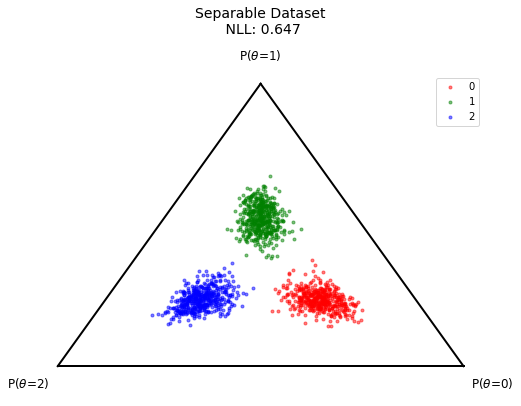

In [10]:
random.seed(1)
easy_target = np.array(random.choices(range(3), k=n_samples))
easy_one_hot = np.zeros((n_samples, 3))
easy_one_hot[np.arange(n_samples), easy_target] = 1.


np.random.seed(2)
easy_logits = np.float32(0.8 * (easy_one_hot + np.random.randn(n_samples, 3)*0.2))

# Equivalent to log(softmax())
easy_logits -= np.log(np.sum(np.exp(easy_logits), axis=1, keepdims=True))

easy_probs = softmax(easy_logits, axis=1)

# Convert data to torch tensors.
torch_easy_logits = torch.as_tensor(easy_logits, dtype=torch.float)
torch_easy_target = torch.as_tensor(easy_one_hot, dtype=torch.float)

fig, ax = plt.subplots(figsize=(8,6))

ax = plot_prob_simplex(easy_probs, easy_target, ax=ax, title='Separable Dataset\n NLL: {:.3f}'.format(nll(easy_probs, easy_one_hot)))

plt.show(fig)

In [12]:
np.save(os.path.join(data_path, 'bayes_separable_logits'), easy_logits)
np.save(os.path.join(data_path, 'bayes_separable_target'), easy_target)

### Mixed

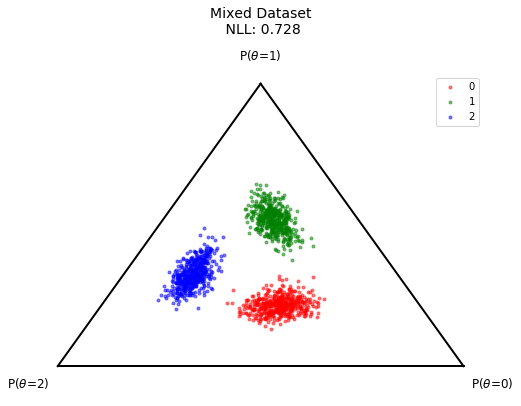

In [23]:
random.seed(4)
hard_target = np.array(random.choices(range(dim), k=n_samples))
hard_one_hot = np.zeros((n_samples, dim))
hard_one_hot[np.arange(n_samples), hard_target] = 1.

# Shift
offset = np.zeros((n_samples, dim))
offset[:, 1:] = 0.2

# Twist
twisting = np.zeros((n_samples, dim))
np.random.seed(5)
twisting[np.arange(n_samples), hard_target-1] = 0.5 + np.random.randn(n_samples)*0.15

np.random.seed(6)
hard_logits = np.float32(0.9 * (hard_one_hot + twisting + np.random.randn(n_samples, dim)*0.15) + offset)

# Equivalent to log(softmax())
hard_logits -= np.log(np.sum(np.exp(hard_logits), axis=1, keepdims=True))

hard_probs = softmax(hard_logits, axis=1)

# Convert data to torch tensors.
torch_hard_logits = torch.as_tensor(hard_logits, dtype=torch.float)
torch_hard_target = torch.as_tensor(hard_one_hot, dtype=torch.float)

fig, ax = plt.subplots(figsize=(8,6))

ax = plot_prob_simplex(hard_probs, hard_target, ax=ax, title='Mixed Dataset\n NLL: {:.3f}'.format(nll(hard_probs, hard_one_hot)))

plt.show(fig)

In [24]:
np.save(os.path.join(data_path, 'twistted_separable_logits'), hard_logits)
np.save(os.path.join(data_path, 'twistted_separable_target'), hard_target)

## Calibration Flow

In [12]:
class CalibrationFlow(nn.Module):
    
    def __init__(self, dim):
        
        super(CalibrationFlow, self).__init__()
        
        self.invertible=True
        self.dim = dim
        self.T = nn.Parameter(torch.ones(1))
        
        self.vs = nn.ParameterList(nn.Parameter(torch.randn(dim, 1, requires_grad=True))
                                   for i in range(dim))
        
    def computeR(self):
        Hs = [torch.eye(self.dim) - 2*torch.mm(v, v.view(1, -1))/torch.mm(v.view(1, -1), v) for v in self.vs]
        R = reduce(lambda A, B: torch.mm(A, B), Hs, torch.eye(self.dim))
        
        return R
                                
        
    def forward(self, x):
        
        # Rotation
        R = self.computeR()
        x = torch.mm(x, R)
        
        # Scale
        z = x/self.T
        
        
        log_det = -torch.sum(torch.ones_like(x)*self.T, dim=1)
        
        return z, log_det
    
    
    def backward(self, z):
        
        # Scale
        T = torch.mm(z, self.w/torch.norm(self.w))
        x = z*T
        
        # Rotation
        R = self.computeR()
        x = torch.mm(x, R.T)
        
        log_det = torch.sum(torch.ones_like(x)*self.T, dim=1)
        
        return x, log_det

## Train Functions

In [31]:
def get_Calmodel():
    return Flow(layers=[CalibrationFlow(dim) for _ in range(5)])

In [32]:
def get_NICEmodel():
     return Flow(layers=[NvpCouplingLayer(dim, [5, 5], scale=False) for _ in range(10)])

In [33]:
def get_NVPmodel():
     return Flow(layers=[NvpCouplingLayer(dim, [5, 5]) for _ in range(10)])

In [34]:
def get_Planarmodel():
     return Flow(layers=[PlanarLayer(dim) for _ in range(10)])

In [35]:
def train_model(model, epochs, logits, target, loss_function, optimizer=None, dev=torch.device('cpu')):
    model = model.to(dev, non_blocking=True)
    
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    
    softmx = nn.Softmax(dim=1)

    loss = []
    logpz = []
    logdet = []

    # Output at some layers
    logits_mean = []
    logits_size = []
    intermediate_results = []

    # Train loop
    t0 = time.time()
    for e in range(epochs):

        cum_loss = torch.zeros(1, device=dev)
        cum_logdet = torch.zeros(1, device=dev)
        cum_logprior = torch.zeros(1, device=dev)

        

        zs, _logdet = model(logits)
        preds = zs[-1]

        _probs = softmx(preds)
        if (preds != preds).any():
            print('Nan in output probabilities, aborting training at epoch: {}'.format(e))
            break

        _loss = loss_function(zs, _logdet, target)
            
        _logdet = torch.mean(_logdet)
        _logpz = torch.mean(torch.sum(target*torch.log(_probs), dim=1))

        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        loss.append(_loss.item())
        logpz.append(_logpz.item())
        logdet.append(_logdet.item())

        

        if e%10 == 9:
            means = []
            sizes = []
            for i in range(0, len(model.layers), len(model.layers)//n_layers):
                z = zs[i].detach().cpu().numpy()
                means.append(np.mean(z))
                sizes.append(np.mean(np.linalg.norm(z-np.mean(z, axis=1, keepdims=True), axis=1)))
            
            logits_mean.append(means)
            logits_size.append(sizes)
            print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}'.format(e, time.time()-t0, loss[-1], logpz[-1])
                  + ', log(det): {:.3f}, mean(logits): {:.3f}, size(logits): {:.3f}'.format(logdet[-1],
                                                                                            np.mean(np.array(logits_mean[-1])),
                                                                                            np.mean(np.array(logits_size[-1])))
                 )
            
            intermediate_results.append(preds.detach().numpy())
            
    return {'model': model,
            'loss': loss,
            'logpz': logpz,
            'logdet': logdet,
            'logits_mean': logits_mean,
            'logits_size': logits_size,
            'intermediate_results': intermediate_results,
            'uncal_nll': nll(softmax(logits.detach().cpu().numpy(), axis=1), target.detach().cpu().numpy()),
           }

In [36]:
def label_smoothing(onehot, alpha=1):
    target = (onehot*(np.sum(onehot, axis=0) + alpha) + (1-onehot)*alpha)/(np.sum(onehot, axis=0, keepdims=True) + dim*alpha)
    return target

In [37]:
CE = nn.CrossEntropyLoss(reduction='mean').to(dev)

def base_loss(zs, _logdet, target):
    preds = zs[-1]
    _, target = target.max(dim=1)
    _logdet = torch.mean(_logdet)
    _nll = CE(preds, target)
    
    _loss = _nll - _logdet
    
    return _loss

## NVP-Flow

In [38]:
model = get_NVPmodel()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

name='nvp-separable'

In [39]:
h = train_model(model, epochs, torch_easy_logits, torch_easy_target, loss_function=base_loss, optimizer=optimizer)

epoch: 9, at time: 0.39, loss: 4.475, log(pz): -0.981, log(det): -3.494, mean(logits): -0.867, size(logits): 0.757
epoch: 19, at time: 0.61, loss: 4.449, log(pz): -0.978, log(det): -3.471, mean(logits): -0.871, size(logits): 0.755
epoch: 29, at time: 0.83, loss: 4.424, log(pz): -0.976, log(det): -3.448, mean(logits): -0.875, size(logits): 0.753
epoch: 39, at time: 1.05, loss: 4.398, log(pz): -0.973, log(det): -3.424, mean(logits): -0.879, size(logits): 0.751
epoch: 49, at time: 1.27, loss: 4.372, log(pz): -0.971, log(det): -3.401, mean(logits): -0.883, size(logits): 0.749
epoch: 59, at time: 1.49, loss: 4.345, log(pz): -0.968, log(det): -3.377, mean(logits): -0.888, size(logits): 0.747
epoch: 69, at time: 1.71, loss: 4.319, log(pz): -0.966, log(det): -3.353, mean(logits): -0.892, size(logits): 0.745
epoch: 79, at time: 1.93, loss: 4.292, log(pz): -0.963, log(det): -3.329, mean(logits): -0.896, size(logits): 0.743
epoch: 89, at time: 2.15, loss: 4.265, log(pz): -0.961, log(det): -3.304,

epoch: 709, at time: 15.87, loss: 1.710, log(pz): -0.753, log(det): -0.957, mean(logits): -1.293, size(logits): 0.886
epoch: 719, at time: 16.09, loss: 1.646, log(pz): -0.748, log(det): -0.898, mean(logits): -1.307, size(logits): 0.891
epoch: 729, at time: 16.32, loss: 1.582, log(pz): -0.744, log(det): -0.838, mean(logits): -1.322, size(logits): 0.897
epoch: 739, at time: 16.55, loss: 1.515, log(pz): -0.739, log(det): -0.776, mean(logits): -1.337, size(logits): 0.903
epoch: 749, at time: 16.76, loss: 1.446, log(pz): -0.734, log(det): -0.712, mean(logits): -1.353, size(logits): 0.910
epoch: 759, at time: 16.98, loss: 1.376, log(pz): -0.730, log(det): -0.646, mean(logits): -1.370, size(logits): 0.918
epoch: 769, at time: 17.20, loss: 1.305, log(pz): -0.725, log(det): -0.580, mean(logits): -1.388, size(logits): 0.927
epoch: 779, at time: 17.42, loss: 1.233, log(pz): -0.721, log(det): -0.511, mean(logits): -1.407, size(logits): 0.936
epoch: 789, at time: 17.64, loss: 1.159, log(pz): -0.717

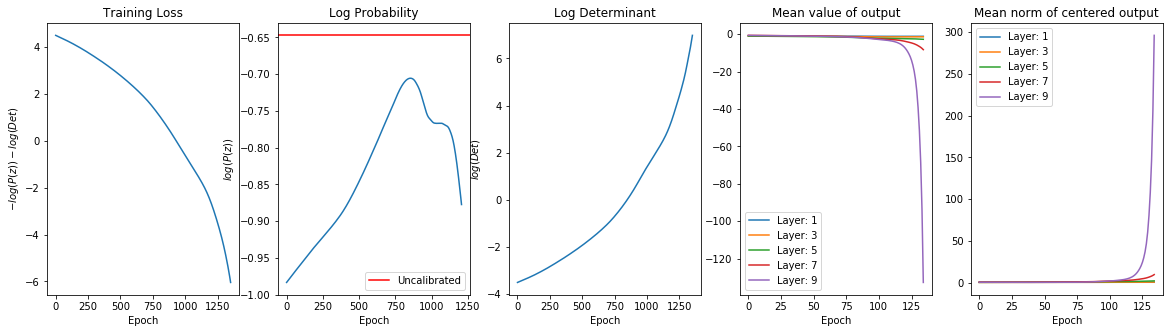

In [40]:
plot_history(h, save=save, name=name)

In [41]:
ani_simplex, ani_logits, ani_probs3d = create_animations(
    h['intermediate_results'], 
    easy_target, 
    save=save, 
    path=save_path, 
    name=name)

In [42]:
HTML(ani_simplex.to_html5_video())

In [43]:
HTML(ani_logits.to_html5_video())

In [34]:
model = get_NVPmodel()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

name='nvp-mixed'

In [35]:
h = train_model(model, epochs, torch_hard_logits, torch_hard_target, loss_function=base_loss, optimizer=optimizer)

epoch: 9, at time: 2.22, loss: 5.201, log(pz): -1.103, log(det): -4.098, mean(logits): -0.867, size(logits): 0.773
epoch: 19, at time: 4.37, loss: 5.174, log(pz): -1.101, log(det): -4.073, mean(logits): -0.868, size(logits): 0.772
epoch: 29, at time: 6.62, loss: 5.146, log(pz): -1.099, log(det): -4.047, mean(logits): -0.869, size(logits): 0.772
epoch: 39, at time: 8.79, loss: 5.119, log(pz): -1.098, log(det): -4.021, mean(logits): -0.869, size(logits): 0.772
epoch: 49, at time: 11.12, loss: 5.092, log(pz): -1.096, log(det): -3.996, mean(logits): -0.870, size(logits): 0.771
epoch: 59, at time: 13.35, loss: 5.064, log(pz): -1.094, log(det): -3.970, mean(logits): -0.871, size(logits): 0.771
epoch: 69, at time: 15.49, loss: 5.037, log(pz): -1.093, log(det): -3.945, mean(logits): -0.871, size(logits): 0.771
epoch: 79, at time: 17.52, loss: 5.010, log(pz): -1.091, log(det): -3.919, mean(logits): -0.872, size(logits): 0.771
epoch: 89, at time: 19.46, loss: 4.983, log(pz): -1.089, log(det): -3

epoch: 709, at time: 145.72, loss: 3.233, log(pz): -0.967, log(det): -2.265, mean(logits): -0.979, size(logits): 0.860
epoch: 719, at time: 147.58, loss: 3.197, log(pz): -0.965, log(det): -2.232, mean(logits): -0.986, size(logits): 0.865
epoch: 729, at time: 149.70, loss: 3.161, log(pz): -0.963, log(det): -2.199, mean(logits): -0.992, size(logits): 0.869
epoch: 739, at time: 151.81, loss: 3.125, log(pz): -0.960, log(det): -2.165, mean(logits): -0.999, size(logits): 0.874
epoch: 749, at time: 153.84, loss: 3.089, log(pz): -0.958, log(det): -2.131, mean(logits): -1.007, size(logits): 0.879
epoch: 759, at time: 155.91, loss: 3.052, log(pz): -0.955, log(det): -2.097, mean(logits): -1.014, size(logits): 0.884
epoch: 769, at time: 157.98, loss: 3.015, log(pz): -0.953, log(det): -2.062, mean(logits): -1.022, size(logits): 0.890
epoch: 779, at time: 160.04, loss: 2.977, log(pz): -0.950, log(det): -2.027, mean(logits): -1.030, size(logits): 0.896
epoch: 789, at time: 162.06, loss: 2.939, log(pz

epoch: 1399, at time: 286.34, loss: -1.105, log(pz): -1.043, log(det): 2.149, mean(logits): -2.572, size(logits): 3.160
epoch: 1409, at time: 288.48, loss: -1.190, log(pz): -1.058, log(det): 2.248, mean(logits): -2.617, size(logits): 3.255
epoch: 1419, at time: 290.65, loss: -1.274, log(pz): -1.073, log(det): 2.347, mean(logits): -2.662, size(logits): 3.352
epoch: 1429, at time: 292.80, loss: -1.358, log(pz): -1.088, log(det): 2.446, mean(logits): -2.708, size(logits): 3.450
epoch: 1439, at time: 294.77, loss: -1.440, log(pz): -1.104, log(det): 2.544, mean(logits): -2.754, size(logits): 3.551
epoch: 1449, at time: 296.76, loss: -1.522, log(pz): -1.119, log(det): 2.641, mean(logits): -2.800, size(logits): 3.653
epoch: 1459, at time: 298.82, loss: -1.602, log(pz): -1.135, log(det): 2.738, mean(logits): -2.847, size(logits): 3.757
epoch: 1469, at time: 300.74, loss: -1.682, log(pz): -1.152, log(det): 2.833, mean(logits): -2.895, size(logits): 3.864
epoch: 1479, at time: 302.59, loss: -1.7

epoch: 2099, at time: 433.10, loss: -3.663, log(pz): nan, log(det): 5.415, mean(logits): -4.397, size(logits): 8.109
epoch: 2109, at time: 435.20, loss: -3.673, log(pz): nan, log(det): 5.426, mean(logits): -4.401, size(logits): 8.120
epoch: 2119, at time: 437.34, loss: -3.684, log(pz): nan, log(det): 5.436, mean(logits): -4.405, size(logits): 8.131
epoch: 2129, at time: 439.47, loss: -3.694, log(pz): nan, log(det): 5.445, mean(logits): -4.408, size(logits): 8.140
epoch: 2139, at time: 441.61, loss: -3.704, log(pz): nan, log(det): 5.454, mean(logits): -4.411, size(logits): 8.146
epoch: 2149, at time: 443.75, loss: -3.714, log(pz): nan, log(det): 5.463, mean(logits): -4.413, size(logits): 8.153
epoch: 2159, at time: 445.91, loss: -3.724, log(pz): nan, log(det): 5.472, mean(logits): -4.415, size(logits): 8.160
epoch: 2169, at time: 448.06, loss: -3.733, log(pz): nan, log(det): 5.481, mean(logits): -4.417, size(logits): 8.166
epoch: 2179, at time: 450.26, loss: -3.743, log(pz): nan, log(de

epoch: 2809, at time: 582.64, loss: -4.417, log(pz): nan, log(det): 6.100, mean(logits): -4.485, size(logits): 8.523
epoch: 2819, at time: 584.70, loss: -4.429, log(pz): nan, log(det): 6.112, mean(logits): -4.476, size(logits): 8.526
epoch: 2829, at time: 586.79, loss: -4.441, log(pz): nan, log(det): 6.128, mean(logits): -4.475, size(logits): 8.543
epoch: 2839, at time: 588.84, loss: -4.454, log(pz): nan, log(det): 6.145, mean(logits): -4.476, size(logits): 8.561
epoch: 2849, at time: 590.92, loss: -4.467, log(pz): nan, log(det): 6.163, mean(logits): -4.473, size(logits): 8.586
epoch: 2859, at time: 593.06, loss: -4.480, log(pz): nan, log(det): 6.179, mean(logits): -4.469, size(logits): 8.598
epoch: 2869, at time: 595.06, loss: -4.493, log(pz): nan, log(det): 6.190, mean(logits): -4.464, size(logits): 8.596
epoch: 2879, at time: 596.99, loss: -4.505, log(pz): nan, log(det): 6.192, mean(logits): -4.458, size(logits): 8.564
epoch: 2889, at time: 598.97, loss: -4.518, log(pz): nan, log(de

epoch: 3519, at time: 725.10, loss: -5.295, log(pz): nan, log(det): 6.807, mean(logits): -4.437, size(logits): 8.329
epoch: 3529, at time: 727.10, loss: -5.307, log(pz): nan, log(det): 6.821, mean(logits): -4.444, size(logits): 8.344
epoch: 3539, at time: 729.08, loss: -5.320, log(pz): nan, log(det): 6.830, mean(logits): -4.450, size(logits): 8.341
epoch: 3549, at time: 731.01, loss: -5.333, log(pz): nan, log(det): 6.839, mean(logits): -4.450, size(logits): 8.336
epoch: 3559, at time: 732.98, loss: -5.344, log(pz): nan, log(det): 6.851, mean(logits): -4.452, size(logits): 8.344
epoch: 3569, at time: 735.01, loss: -5.356, log(pz): nan, log(det): 6.858, mean(logits): -4.454, size(logits): 8.332
epoch: 3579, at time: 736.97, loss: -5.369, log(pz): nan, log(det): 6.871, mean(logits): -4.459, size(logits): 8.343
epoch: 3589, at time: 739.12, loss: -5.381, log(pz): nan, log(det): 6.882, mean(logits): -4.462, size(logits): 8.347
epoch: 3599, at time: 741.28, loss: -5.393, log(pz): nan, log(de

epoch: 4229, at time: 870.56, loss: -6.270, log(pz): nan, log(det): 7.676, mean(logits): -4.721, size(logits): 9.017
epoch: 4239, at time: 872.72, loss: -6.288, log(pz): nan, log(det): 7.700, mean(logits): -4.761, size(logits): 9.165
epoch: 4249, at time: 874.87, loss: -6.305, log(pz): nan, log(det): 7.725, mean(logits): -4.810, size(logits): 9.334
epoch: 4259, at time: 876.97, loss: -6.320, log(pz): nan, log(det): 7.748, mean(logits): -4.859, size(logits): 9.507
epoch: 4269, at time: 879.04, loss: -6.337, log(pz): nan, log(det): 7.768, mean(logits): -4.915, size(logits): 9.682
epoch: 4279, at time: 881.08, loss: -6.356, log(pz): nan, log(det): 7.778, mean(logits): -4.946, size(logits): 9.825
epoch: 4289, at time: 883.16, loss: -6.372, log(pz): nan, log(det): 7.787, mean(logits): -4.976, size(logits): 9.979
epoch: 4299, at time: 885.36, loss: -6.390, log(pz): nan, log(det): 7.808, mean(logits): -5.053, size(logits): 10.221
Nan in output probabilities, aborting training at epoch: 4309


In [36]:
ani_simplex, ani_logits, ani_probs3d = create_animations(
    h['intermediate_results'], 
    easy_target, 
    save=save, 
    path=save_path, 
    name=name)

In [37]:
HTML(ani_simplex.to_html5_video())

In [38]:
HTML(ani_logits.to_html5_video())

## Clamp logit values

In [66]:
class ClampingFlow(nn.Module):
    def __init__(self, layers, **kwargs):
        super(ClampingFlow, self).__init__()

        self.layers = nn.ModuleList(layers)

        # A flow is (computationally) invertible if all its layers are.
        self.invertible = all([layer.invertible for layer in self.layers])

    def forward(self, x):
        cum_log_det = 0.0
        zs = []
        for layer in self.layers:
            x, log_det = layer(x)
            x = torch.tanh(x)*5
            zs.append(x)
            cum_log_det += log_det + torch.sum(torch.log(torch.abs(1 - x**2)/5), dim=1)

        return zs, cum_log_det

    def backward(self, z):
        if not self.invertible:
            raise ValueError('Flow inverse not tractable!')
        cum_log_det = 0.0
        xs = []
        for layer in self.layers[::-1]:
            z, log_det = layer.backward(z)
            z = torch.clamp(z, min=-5., max=5.)
            xs.append(z)
            cum_log_det += log_det

        return xs, cum_log_det

## Planar-like

In [67]:
def train_planar(model, epochs, logits, target, loss_function, optimizer=None, dev=torch.device('cpu')):
    model = model.to(dev, non_blocking=True)
    
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    
    softmx = nn.Softmax(dim=1)

    loss = []
    logpz = []
    logdet = []

    # Parameters
    ws = []
    us = []
    bs = []
    intermediate_results = []

    # Train loop
    t0 = time.time()
    for e in range(epochs):

        cum_loss = torch.zeros(1, device=dev)
        cum_logdet = torch.zeros(1, device=dev)
        cum_logprior = torch.zeros(1, device=dev)

        

        zs, _logdet = model(logits)
        preds = zs[-1]

        _probs = softmx(preds)
        if (preds != preds).any():
            print('Nan in output probabilities, aborting training at epoch: {}'.format(e))
            break

        _loss = loss_function(zs, _logdet, target)
            
        _logdet = torch.mean(_logdet)
        _logpz = torch.mean(torch.sum(target*torch.log(_probs), dim=1))

        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        loss.append(_loss.item())
        logpz.append(_logpz.item())
        logdet.append(_logdet.item())

        if e%10 == 9:
            print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}'.format(e, time.time()-t0, loss[-1], logpz[-1])
                  + ', log(det): {:.3f}'.format(logdet[-1],))
            
            # Monitor parameters
            ws_ = []
            us_ = []
            bs_ = []
            for i in range(0, len(model.layers), len(model.layers)//n_layers):
                layer = model.layers[i]
                ws_.append(np.linalg.norm(layer.w.detach().cpu().numpy()))
                us_.append(np.linalg.norm(layer.u.detach().cpu().numpy()))
                bs_.append(layer.b.item())
                
            ws.append(ws_)
            us.append(us_)
            bs.append(bs_)
            
            
            intermediate_results.append(preds.detach().numpy())
            
    return {'model': model,
            'loss': loss,
            'logpz': logpz,
            'logdet': logdet,
            'ws': ws,
            'us': us,
            'bs': bs,
            'intermediate_results': intermediate_results,
            'uncal_nll': nll(softmax(logits.detach().cpu().numpy(), axis=1), target.detach().cpu().numpy()),
           }

In [68]:
def plot_history_planar(h, save=False, name='history'):
    # Plot training NLL
    fig, ax = plt.subplots(2, 3, figsize=(20, 12))

    ax[0, 0].plot(h['loss'])
    ax[0, 1].plot(h['logpz'])
    ax[0, 1].axhline(-h['uncal_nll'], c='r', label='Uncalibrated')
    ax[0, 2].plot(h['logdet'])
    ax[1, 0].plot(np.array(h['ws']))
    ax[1, 1].plot(np.array(h['us']))
    ax[1, 2].plot(np.array(h['bs']))


    ax[0, 0].set_title('Training Loss')
    ax[0, 0].set_ylabel(r'$-log(P(z)) - log(Det)$')
    ax[0, 0].set_xlabel('Epoch')

    ax[0, 1].set_title('Log Probability')
    ax[0, 1].set_ylabel(r'$log(P(z))$')
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].legend()

    ax[0, 2].set_title('Log Determinant')
    ax[0, 2].set_ylabel(r'$log(Det)$')
    ax[0, 2].set_xlabel('Epoch')

    ax[1, 0].set_title('$|w|$')
    ax[1, 0].set_xlabel('Epoch')
    ax[1, 0].legend(['Layer: {}'.format(i+1) for i in range(0, len(h['model'].layers), len(h['model'].layers)//n_layers)])

    ax[1, 1].set_title('$|u|$')
    ax[1, 1].set_xlabel('Epoch')
    ax[1, 1].legend(['Layer: {}'.format(i+1) for i in range(0, len(h['model'].layers), len(h['model'].layers)//n_layers)])
    
    ax[1, 2].set_title('$b$')
    ax[1, 2].set_xlabel('Epoch')
    ax[1, 2].legend(['Layer: {}'.format(i+1) for i in range(0, len(h['model'].layers), len(h['model'].layers)//n_layers)])

    plt.show(fig)
    
    if save:
        fig.savefig(os.path.join(save_path, name) + '-train.png', dpi=300)

## Clampling NVP

In [69]:
# Instantiate model and optimizer
model = ClampingFlow(layers=[NvpCouplingLayer(dim, [5, 5]) for _ in range(10)])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

name='clamping-nvp-separable'

In [70]:
h = train_model(model, epochs, torch_easy_logits, torch_easy_target, base_loss, optimizer=optimizer, dev=dev)

epoch: 9, at time: 0.26, loss: -40.050, log(pz): -1.099, log(det): 41.148, mean(logits): -4.801, size(logits): 0.247
epoch: 19, at time: 0.51, loss: -40.093, log(pz): -1.099, log(det): 41.191, mean(logits): -4.802, size(logits): 0.246
epoch: 29, at time: 0.77, loss: -40.136, log(pz): -1.099, log(det): 41.234, mean(logits): -4.802, size(logits): 0.246
epoch: 39, at time: 1.03, loss: -40.179, log(pz): -1.099, log(det): 41.277, mean(logits): -4.803, size(logits): 0.246
epoch: 49, at time: 1.29, loss: -40.221, log(pz): -1.099, log(det): 41.320, mean(logits): -4.803, size(logits): 0.245
epoch: 59, at time: 1.55, loss: -40.264, log(pz): -1.099, log(det): 41.362, mean(logits): -4.803, size(logits): 0.245
epoch: 69, at time: 1.82, loss: -40.306, log(pz): -1.099, log(det): 41.404, mean(logits): -4.804, size(logits): 0.244
epoch: 79, at time: 2.07, loss: -40.348, log(pz): -1.099, log(det): 41.446, mean(logits): -4.804, size(logits): 0.244
epoch: 89, at time: 2.33, loss: -40.390, log(pz): -1.099,

epoch: 699, at time: 17.97, loss: -42.989, log(pz): -1.099, log(det): 44.088, mean(logits): -4.825, size(logits): 0.229
epoch: 709, at time: 18.22, loss: -43.035, log(pz): -1.099, log(det): 44.134, mean(logits): -4.826, size(logits): 0.229
epoch: 719, at time: 18.47, loss: -43.082, log(pz): -1.099, log(det): 44.181, mean(logits): -4.826, size(logits): 0.228
epoch: 729, at time: 18.72, loss: -43.129, log(pz): -1.099, log(det): 44.227, mean(logits): -4.826, size(logits): 0.228
epoch: 739, at time: 18.98, loss: -43.176, log(pz): -1.099, log(det): 44.274, mean(logits): -4.827, size(logits): 0.228
epoch: 749, at time: 19.23, loss: -43.222, log(pz): -1.099, log(det): 44.321, mean(logits): -4.827, size(logits): 0.228
epoch: 759, at time: 19.48, loss: -43.267, log(pz): -1.099, log(det): 44.366, mean(logits): -4.827, size(logits): 0.228
epoch: 769, at time: 19.73, loss: -43.313, log(pz): -1.099, log(det): 44.412, mean(logits): -4.827, size(logits): 0.228
epoch: 779, at time: 19.98, loss: -43.35

epoch: 1379, at time: 35.23, loss: -46.476, log(pz): -1.099, log(det): 47.574, mean(logits): -4.842, size(logits): 0.231
epoch: 1389, at time: 35.50, loss: -46.529, log(pz): -1.099, log(det): 47.627, mean(logits): -4.843, size(logits): 0.231
epoch: 1399, at time: 35.76, loss: -46.581, log(pz): -1.099, log(det): 47.680, mean(logits): -4.843, size(logits): 0.231
epoch: 1409, at time: 36.02, loss: -46.634, log(pz): -1.099, log(det): 47.732, mean(logits): -4.843, size(logits): 0.231
epoch: 1419, at time: 36.27, loss: -46.687, log(pz): -1.099, log(det): 47.785, mean(logits): -4.843, size(logits): 0.232
epoch: 1429, at time: 36.53, loss: -46.739, log(pz): -1.099, log(det): 47.838, mean(logits): -4.843, size(logits): 0.232
epoch: 1439, at time: 36.79, loss: -46.792, log(pz): -1.099, log(det): 47.890, mean(logits): -4.843, size(logits): 0.232
epoch: 1449, at time: 37.04, loss: -46.844, log(pz): -1.099, log(det): 47.943, mean(logits): -4.844, size(logits): 0.232
epoch: 1459, at time: 37.30, los

epoch: 2059, at time: 52.54, loss: -49.912, log(pz): -1.099, log(det): 51.011, mean(logits): -4.851, size(logits): 0.243
epoch: 2069, at time: 52.78, loss: -49.959, log(pz): -1.099, log(det): 51.058, mean(logits): -4.851, size(logits): 0.243
epoch: 2079, at time: 53.03, loss: -50.007, log(pz): -1.099, log(det): 51.105, mean(logits): -4.851, size(logits): 0.243
epoch: 2089, at time: 53.28, loss: -50.054, log(pz): -1.099, log(det): 51.152, mean(logits): -4.851, size(logits): 0.243
epoch: 2099, at time: 53.53, loss: -50.101, log(pz): -1.099, log(det): 51.199, mean(logits): -4.851, size(logits): 0.243
epoch: 2109, at time: 53.78, loss: -50.148, log(pz): -1.099, log(det): 51.246, mean(logits): -4.851, size(logits): 0.243
epoch: 2119, at time: 54.03, loss: -50.194, log(pz): -1.099, log(det): 51.293, mean(logits): -4.851, size(logits): 0.243
epoch: 2129, at time: 54.28, loss: -50.241, log(pz): -1.099, log(det): 51.340, mean(logits): -4.851, size(logits): 0.243
epoch: 2139, at time: 54.53, los

epoch: 2739, at time: 70.89, loss: -52.903, log(pz): -1.099, log(det): 54.001, mean(logits): -4.853, size(logits): 0.247
epoch: 2749, at time: 71.16, loss: -52.943, log(pz): -1.099, log(det): 54.042, mean(logits): -4.853, size(logits): 0.247
epoch: 2759, at time: 71.42, loss: -52.984, log(pz): -1.099, log(det): 54.083, mean(logits): -4.853, size(logits): 0.247
epoch: 2769, at time: 71.67, loss: -53.024, log(pz): -1.099, log(det): 54.123, mean(logits): -4.853, size(logits): 0.247
epoch: 2779, at time: 71.92, loss: -53.065, log(pz): -1.099, log(det): 54.163, mean(logits): -4.853, size(logits): 0.247
epoch: 2789, at time: 72.17, loss: -53.105, log(pz): -1.099, log(det): 54.204, mean(logits): -4.853, size(logits): 0.247
epoch: 2799, at time: 72.43, loss: -53.145, log(pz): -1.099, log(det): 54.244, mean(logits): -4.853, size(logits): 0.247
epoch: 2809, at time: 72.69, loss: -53.185, log(pz): -1.099, log(det): 54.284, mean(logits): -4.853, size(logits): 0.247
epoch: 2819, at time: 72.94, los

epoch: 3419, at time: 88.21, loss: -55.473, log(pz): -1.099, log(det): 56.571, mean(logits): -4.854, size(logits): 0.248
epoch: 3429, at time: 88.46, loss: -55.508, log(pz): -1.099, log(det): 56.607, mean(logits): -4.854, size(logits): 0.248
epoch: 3439, at time: 88.71, loss: -55.543, log(pz): -1.099, log(det): 56.642, mean(logits): -4.854, size(logits): 0.248
epoch: 3449, at time: 88.96, loss: -55.578, log(pz): -1.099, log(det): 56.677, mean(logits): -4.854, size(logits): 0.248
epoch: 3459, at time: 89.21, loss: -55.613, log(pz): -1.099, log(det): 56.712, mean(logits): -4.854, size(logits): 0.248
epoch: 3469, at time: 89.46, loss: -55.648, log(pz): -1.099, log(det): 56.746, mean(logits): -4.854, size(logits): 0.248
epoch: 3479, at time: 89.71, loss: -55.683, log(pz): -1.099, log(det): 56.781, mean(logits): -4.854, size(logits): 0.248
epoch: 3489, at time: 89.96, loss: -55.717, log(pz): -1.099, log(det): 56.816, mean(logits): -4.854, size(logits): 0.248
epoch: 3499, at time: 90.21, los

epoch: 4099, at time: 105.30, loss: -57.732, log(pz): -1.099, log(det): 58.830, mean(logits): -4.854, size(logits): 0.248
epoch: 4109, at time: 105.55, loss: -57.763, log(pz): -1.099, log(det): 58.862, mean(logits): -4.854, size(logits): 0.248
epoch: 4119, at time: 105.80, loss: -57.794, log(pz): -1.099, log(det): 58.893, mean(logits): -4.854, size(logits): 0.248
epoch: 4129, at time: 106.05, loss: -57.826, log(pz): -1.099, log(det): 58.924, mean(logits): -4.854, size(logits): 0.248
epoch: 4139, at time: 106.30, loss: -57.857, log(pz): -1.099, log(det): 58.956, mean(logits): -4.854, size(logits): 0.248
epoch: 4149, at time: 106.55, loss: -57.888, log(pz): -1.099, log(det): 58.987, mean(logits): -4.854, size(logits): 0.248
epoch: 4159, at time: 106.80, loss: -57.919, log(pz): -1.099, log(det): 59.018, mean(logits): -4.854, size(logits): 0.248
epoch: 4169, at time: 107.05, loss: -57.950, log(pz): -1.099, log(det): 59.049, mean(logits): -4.854, size(logits): 0.248
epoch: 4179, at time: 10

epoch: 4779, at time: 122.50, loss: -59.761, log(pz): -1.099, log(det): 60.860, mean(logits): -4.854, size(logits): 0.248
epoch: 4789, at time: 122.74, loss: -59.789, log(pz): -1.099, log(det): 60.888, mean(logits): -4.854, size(logits): 0.248
epoch: 4799, at time: 122.99, loss: -59.818, log(pz): -1.099, log(det): 60.916, mean(logits): -4.854, size(logits): 0.248
epoch: 4809, at time: 123.24, loss: -59.846, log(pz): -1.099, log(det): 60.945, mean(logits): -4.854, size(logits): 0.248
epoch: 4819, at time: 123.49, loss: -59.874, log(pz): -1.099, log(det): 60.973, mean(logits): -4.854, size(logits): 0.248
epoch: 4829, at time: 123.74, loss: -59.903, log(pz): -1.099, log(det): 61.001, mean(logits): -4.854, size(logits): 0.248
epoch: 4839, at time: 123.99, loss: -59.931, log(pz): -1.099, log(det): 61.030, mean(logits): -4.854, size(logits): 0.248
epoch: 4849, at time: 124.24, loss: -59.959, log(pz): -1.099, log(det): 61.058, mean(logits): -4.854, size(logits): 0.248
epoch: 4859, at time: 12

epoch: 5459, at time: 139.67, loss: -61.618, log(pz): -1.099, log(det): 62.716, mean(logits): -4.854, size(logits): 0.248
epoch: 5469, at time: 139.94, loss: -61.644, log(pz): -1.099, log(det): 62.742, mean(logits): -4.854, size(logits): 0.248
epoch: 5479, at time: 140.21, loss: -61.670, log(pz): -1.099, log(det): 62.769, mean(logits): -4.854, size(logits): 0.248
epoch: 5489, at time: 140.47, loss: -61.696, log(pz): -1.099, log(det): 62.795, mean(logits): -4.854, size(logits): 0.248
epoch: 5499, at time: 140.72, loss: -61.722, log(pz): -1.099, log(det): 62.821, mean(logits): -4.854, size(logits): 0.248
epoch: 5509, at time: 140.97, loss: -61.749, log(pz): -1.099, log(det): 62.847, mean(logits): -4.854, size(logits): 0.248
epoch: 5519, at time: 141.22, loss: -61.775, log(pz): -1.099, log(det): 62.873, mean(logits): -4.854, size(logits): 0.248
epoch: 5529, at time: 141.48, loss: -61.801, log(pz): -1.099, log(det): 62.899, mean(logits): -4.854, size(logits): 0.248
epoch: 5539, at time: 14

epoch: 6139, at time: 156.85, loss: -63.342, log(pz): -1.099, log(det): 64.441, mean(logits): -4.854, size(logits): 0.248
epoch: 6149, at time: 157.10, loss: -63.367, log(pz): -1.099, log(det): 64.465, mean(logits): -4.854, size(logits): 0.248
epoch: 6159, at time: 157.36, loss: -63.391, log(pz): -1.099, log(det): 64.490, mean(logits): -4.854, size(logits): 0.248
epoch: 6169, at time: 157.61, loss: -63.416, log(pz): -1.099, log(det): 64.514, mean(logits): -4.854, size(logits): 0.248
epoch: 6179, at time: 157.86, loss: -63.440, log(pz): -1.099, log(det): 64.539, mean(logits): -4.854, size(logits): 0.248
epoch: 6189, at time: 158.11, loss: -63.464, log(pz): -1.099, log(det): 64.563, mean(logits): -4.854, size(logits): 0.248
epoch: 6199, at time: 158.36, loss: -63.489, log(pz): -1.099, log(det): 64.588, mean(logits): -4.854, size(logits): 0.248
epoch: 6209, at time: 158.61, loss: -63.513, log(pz): -1.099, log(det): 64.612, mean(logits): -4.854, size(logits): 0.248
epoch: 6219, at time: 15

epoch: 6819, at time: 174.42, loss: -64.958, log(pz): -1.099, log(det): 66.056, mean(logits): -4.854, size(logits): 0.248
epoch: 6829, at time: 174.68, loss: -64.981, log(pz): -1.099, log(det): 66.079, mean(logits): -4.854, size(logits): 0.248
epoch: 6839, at time: 174.94, loss: -65.004, log(pz): -1.099, log(det): 66.102, mean(logits): -4.854, size(logits): 0.248
epoch: 6849, at time: 175.20, loss: -65.027, log(pz): -1.099, log(det): 66.125, mean(logits): -4.854, size(logits): 0.248
epoch: 6859, at time: 175.45, loss: -65.050, log(pz): -1.099, log(det): 66.148, mean(logits): -4.854, size(logits): 0.248
epoch: 6869, at time: 175.70, loss: -65.073, log(pz): -1.099, log(det): 66.171, mean(logits): -4.854, size(logits): 0.248
epoch: 6879, at time: 175.95, loss: -65.096, log(pz): -1.099, log(det): 66.194, mean(logits): -4.854, size(logits): 0.248
epoch: 6889, at time: 176.20, loss: -65.118, log(pz): -1.099, log(det): 66.217, mean(logits): -4.854, size(logits): 0.248
epoch: 6899, at time: 17

epoch: 7499, at time: 191.38, loss: -66.479, log(pz): -1.099, log(det): 67.578, mean(logits): -4.854, size(logits): 0.248
epoch: 7509, at time: 191.63, loss: -66.501, log(pz): -1.099, log(det): 67.600, mean(logits): -4.854, size(logits): 0.248
epoch: 7519, at time: 191.88, loss: -66.523, log(pz): -1.099, log(det): 67.621, mean(logits): -4.854, size(logits): 0.248
epoch: 7529, at time: 192.12, loss: -66.544, log(pz): -1.099, log(det): 67.643, mean(logits): -4.854, size(logits): 0.248
epoch: 7539, at time: 192.37, loss: -66.566, log(pz): -1.099, log(det): 67.665, mean(logits): -4.854, size(logits): 0.248
epoch: 7549, at time: 192.62, loss: -66.588, log(pz): -1.099, log(det): 67.686, mean(logits): -4.854, size(logits): 0.248
epoch: 7559, at time: 192.87, loss: -66.609, log(pz): -1.099, log(det): 67.708, mean(logits): -4.854, size(logits): 0.248
epoch: 7569, at time: 193.12, loss: -66.631, log(pz): -1.099, log(det): 67.730, mean(logits): -4.854, size(logits): 0.248
epoch: 7579, at time: 19

epoch: 8179, at time: 208.31, loss: -67.918, log(pz): -1.099, log(det): 69.017, mean(logits): -4.854, size(logits): 0.248
epoch: 8189, at time: 208.55, loss: -67.939, log(pz): -1.099, log(det): 69.037, mean(logits): -4.854, size(logits): 0.248
epoch: 8199, at time: 208.80, loss: -67.959, log(pz): -1.099, log(det): 69.058, mean(logits): -4.854, size(logits): 0.248
epoch: 8209, at time: 209.05, loss: -67.980, log(pz): -1.099, log(det): 69.079, mean(logits): -4.854, size(logits): 0.248
epoch: 8219, at time: 209.29, loss: -68.000, log(pz): -1.099, log(det): 69.099, mean(logits): -4.854, size(logits): 0.248
epoch: 8229, at time: 209.54, loss: -68.021, log(pz): -1.099, log(det): 69.120, mean(logits): -4.854, size(logits): 0.248
epoch: 8239, at time: 209.79, loss: -68.041, log(pz): -1.099, log(det): 69.140, mean(logits): -4.854, size(logits): 0.248
epoch: 8249, at time: 210.04, loss: -68.062, log(pz): -1.099, log(det): 69.161, mean(logits): -4.854, size(logits): 0.248
epoch: 8259, at time: 21

epoch: 8859, at time: 225.22, loss: -69.283, log(pz): -1.099, log(det): 70.382, mean(logits): -4.854, size(logits): 0.248
epoch: 8869, at time: 225.47, loss: -69.303, log(pz): -1.099, log(det): 70.401, mean(logits): -4.854, size(logits): 0.248
epoch: 8879, at time: 225.72, loss: -69.322, log(pz): -1.099, log(det): 70.421, mean(logits): -4.854, size(logits): 0.248
epoch: 8889, at time: 225.97, loss: -69.342, log(pz): -1.099, log(det): 70.441, mean(logits): -4.854, size(logits): 0.248
epoch: 8899, at time: 226.22, loss: -69.361, log(pz): -1.099, log(det): 70.460, mean(logits): -4.854, size(logits): 0.248
epoch: 8909, at time: 226.47, loss: -69.381, log(pz): -1.099, log(det): 70.480, mean(logits): -4.854, size(logits): 0.248
epoch: 8919, at time: 226.73, loss: -69.400, log(pz): -1.099, log(det): 70.499, mean(logits): -4.854, size(logits): 0.248
epoch: 8929, at time: 226.98, loss: -69.420, log(pz): -1.099, log(det): 70.519, mean(logits): -4.854, size(logits): 0.248
epoch: 8939, at time: 22

epoch: 9539, at time: 242.24, loss: -70.582, log(pz): -1.099, log(det): 71.680, mean(logits): -4.854, size(logits): 0.248
epoch: 9549, at time: 242.49, loss: -70.600, log(pz): -1.099, log(det): 71.699, mean(logits): -4.854, size(logits): 0.248
epoch: 9559, at time: 242.74, loss: -70.619, log(pz): -1.099, log(det): 71.718, mean(logits): -4.854, size(logits): 0.248
epoch: 9569, at time: 242.99, loss: -70.638, log(pz): -1.099, log(det): 71.736, mean(logits): -4.854, size(logits): 0.248
epoch: 9579, at time: 243.24, loss: -70.656, log(pz): -1.099, log(det): 71.755, mean(logits): -4.854, size(logits): 0.248
epoch: 9589, at time: 243.50, loss: -70.675, log(pz): -1.099, log(det): 71.773, mean(logits): -4.854, size(logits): 0.248
epoch: 9599, at time: 243.75, loss: -70.693, log(pz): -1.099, log(det): 71.792, mean(logits): -4.854, size(logits): 0.248
epoch: 9609, at time: 244.01, loss: -70.712, log(pz): -1.099, log(det): 71.811, mean(logits): -4.854, size(logits): 0.248
epoch: 9619, at time: 24

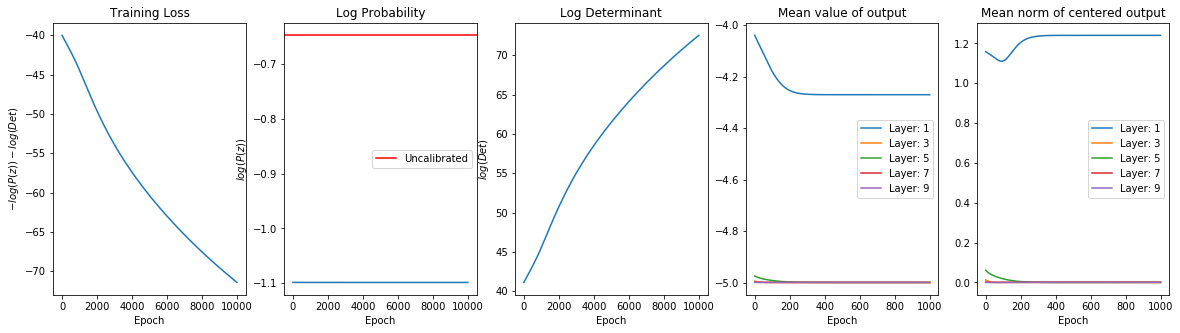

In [71]:
plot_history(h, save=save, name=name)

In [63]:
ani_simplex, ani_logits, ani_probs3d = create_animations(
    h['intermediate_results'], 
    easy_target, 
    save=save, 
    path=save_path, 
    name=name)

In [64]:
HTML(ani_simplex.to_html5_video())

In [65]:
HTML(ani_logits.to_html5_video())

### Mixed Case

In [ ]:
# Instantiate model and optimizer
model = ClampingFlow(layers=[NvpCouplingLayer(dim, [5, 5]) for _ in range(10)])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

name='clampling-nvp-mixed'

In [ ]:
h = train_model(model, epochs, torch_hard_logits, torch_hard_target, base_loss, optimizer=optimizer, dev=dev)

In [ ]:
plot_history(h, save=save, name=name)

In [ ]:
ani_simplex, ani_logits, ani_probs3d = create_animations(
    h['intermediate_results'], 
    easy_target, 
    save=save, 
    path=save_path, 
    name=name)

In [ ]:
HTML(ani_simplex.to_html5_video())

In [ ]:
HTML(ani_logits.to_html5_video())